# Behavioral Cloning

Project 3 using keras.

In [61]:
import pandas as pd
import numpy as np
import math
import glob
import os
import csv
import tensorflow as tf
import keras
import random
import cv2
tf.python.control_flow_ops = tf

import PIL
from PIL import Image
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation, Flatten, BatchNormalization, MaxPooling2D, \
                         Dropout, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from matplotlib import pyplot as plt

In [27]:
csv_data_fname = 'data/epoch_2/driving_log.csv'
img_location_base = 'data/epoch_2/IMG/'
all_images = glob.glob(os.path.join(img_location_base,'*.jpg'))

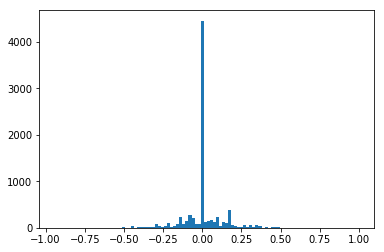

(160, 320, 3)
(8036, 160, 320, 3)


In [28]:
driving_dat = pd.read_csv(csv_data_fname)
driving_dat.head()

plt.hist(driving_dat.iloc[:,3],100)
plt.show()
#load a single image to get dimensions
img = Image.open(os.path.join(img_location_base, os.path.basename(driving_dat.iloc[0,0])))
img_np = np.asarray(img)

img_shape = img_np.shape
print(img_shape)

num_samples = len(driving_dat.iloc[:,3])
print((num_samples,) + img_shape)




[1, 2, 3, 4, 5, 6, 7, 8, 9]
[3128, 5203, 5436, 3523, 1121, 2107, 2622, 1185, 2040]
(5675, 7)
(5175, 7)
center      IMG/center_2016_12_01_13_31_12_937.jpg
left          IMG/left_2016_12_01_13_31_12_937.jpg
right        IMG/right_2016_12_01_13_31_12_937.jpg
steering                                         0
throttle                                         0
brake                                            0
speed                                      1.45301
Name: 1, dtype: object


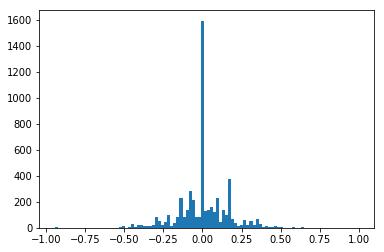

In [59]:
#balance the dataset to have less zeros
num_straight_images = 1500
ix = driving_dat[driving_dat.iloc[:,3]==0]
drop_num = len(ix)-num_straight_images
ix_list = ix.index.tolist()
print(ix_list[1:10])
random.shuffle(ix_list)
print(ix_list[1:10])
print(driving_dat.shape)
driving_dat.drop(ix_list[0:drop_num],inplace=True)
print(driving_dat.shape)
print(driving_dat.iloc[0,:])
plt.hist(driving_dat.iloc[:,3],100)
plt.show()
driving_dat.reset_index(drop=True, inplace=True)

In [60]:
l = driving_dat.iloc[:,3].tolist()
print(len(list(filter(lambda x: x < 0,l))))
print(len(list(filter(lambda x: x > 0,l))))
print(len(list(filter(lambda x: x == 0,l))))



1775
1900
1500


In [83]:
def randomize_light(img):
    image1 = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def flip_image(img):
    return np.fliplr(img)

def randomize_sample(img, label):
    img = randomize_light(img)
    if label < 0 or label > 0:
      if random.random()<0.5:
        label = -label
        img = flip_image(img)
    
    return (img,label)
     

In [84]:
def generate_data(img_location, driving_dat, batch_size):
    
    y = driving_dat.iloc[:,3]
    im_scale = (64,64)
    
    num_samples = len(y)
    img = Image.open(os.path.join(img_location, os.path.basename(driving_dat.iloc[0,0]))) 
    img_np = np.asarray(img)
    img_shape = img_np.shape
    print(img_shape)
    train_shape = (batch_size,) + img_shape
    num_batches = int(np.round(num_samples/batch_size))-1
    print("num batches is " + str(num_batches))
    
    X_train = np.empty(train_shape)
    y_train = np.empty(batch_size)
    while 1:
      total_sample = 0
      for batch in range(1, num_batches):
         for sample in range(0, batch_size-1): 
               rand_sample = random.randint(0,num_samples-1)
               img = Image.open(os.path.join(img_location_base, os.path.basename(driving_dat.iloc[rand_sample,0])))
               img_samp, y_samp = randomize_sample(np.asarray(img), y[rand_sample])
               X_train[sample, :, :, :] = img_samp
               y_train[sample] = y_samp
         yield (X_train, y_train)


In [103]:
# Build model



nb_filters = 32
nb_pool = 2 # max pool dim
nb_conv = 3
#img_shape = (64,64,3)
print(img_shape)

model = Sequential()
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=img_shape))
model.add(Lambda(lambda x: (x/255.0) - 0.5))
model.add(Convolution2D(16,3,3, subsample=(2,2), activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(32,3,3,subsample=(2,2), activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(64,3,3, activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(64))
model.add(Dense(8))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='Adam')

(160, 320, 3)


In [104]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_20 (Cropping2D)       (None, 90, 320, 3)    0           cropping2d_input_20[0][0]        
____________________________________________________________________________________________________
lambda_20 (Lambda)               (None, 90, 320, 3)    0           cropping2d_20[0][0]              
____________________________________________________________________________________________________
convolution2d_42 (Convolution2D) (None, 44, 159, 16)   448         lambda_20[0][0]                  
____________________________________________________________________________________________________
maxpooling2d_41 (MaxPooling2D)   (None, 22, 79, 16)    0           convolution2d_42[0][0]           
___________________________________________________________________________________________

In [106]:
batch_size = 128
nb_epoch = 20

g= generate_data(img_location_base, driving_dat, batch_size)
output= g.__next__()
print(output[0].shape)
print(output[1].shape)
keras.backend.get_session().run(tf.global_variables_initializer())
#history = model.fit(output[0], output[1])
history = model.fit_generator(generate_data(img_location_base, driving_dat, batch_size), 
                             samples_per_epoch=batch_size*10, nb_epoch=nb_epoch, pickle_safe=False, max_q_size=1)


model.save('model.h5')


(160, 320, 3)
num batches is 39
(128, 160, 320, 3)
(128,)
Epoch 1/20
(160, 320, 3)
num batches is 39
1280/1280 [==============================] - 4s - loss: 0.0610     
Epoch 2/20
1280/1280 [==============================] - 4s - loss: 0.0281     

In [57]:
y=driving_dat.iloc[:,3]

print(y.iloc[0])
i=1
for batch in generate_data(img_location_base, driving_dat, batch_size):
    print(batch[0].shape)
    i = i+1
    if i>50:
        break

0.0
(160, 320, 3)
num batches is 43
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)


In [15]:
print(history.history)
g= generate_data(img_location_base, csv_data_fname, batch_size)
output= g.__next__()

metrics = model.evaluate(output[0],output[1])
print(metrics)

{'loss': [inf, nan, nan, nan, nan]}


AttributeError: 'str' object has no attribute 'iloc'

In [ ]:
for metric_i in range(len(model.metrics_names)):
    print(model.metrics_names[metric_i])
    print(model.metrics[metric_i])
    